In [ ]:
###
    # This code plot the simulated Permafrost area from 1980 to 2100 (2015–2100, SSP5-8.5 scenario) in 25 models.
    # Mark asterisks on models that simulate historical permafrost areas over northern Eurasia below 4.0 million km2.
    # Output: Figure S10.
###

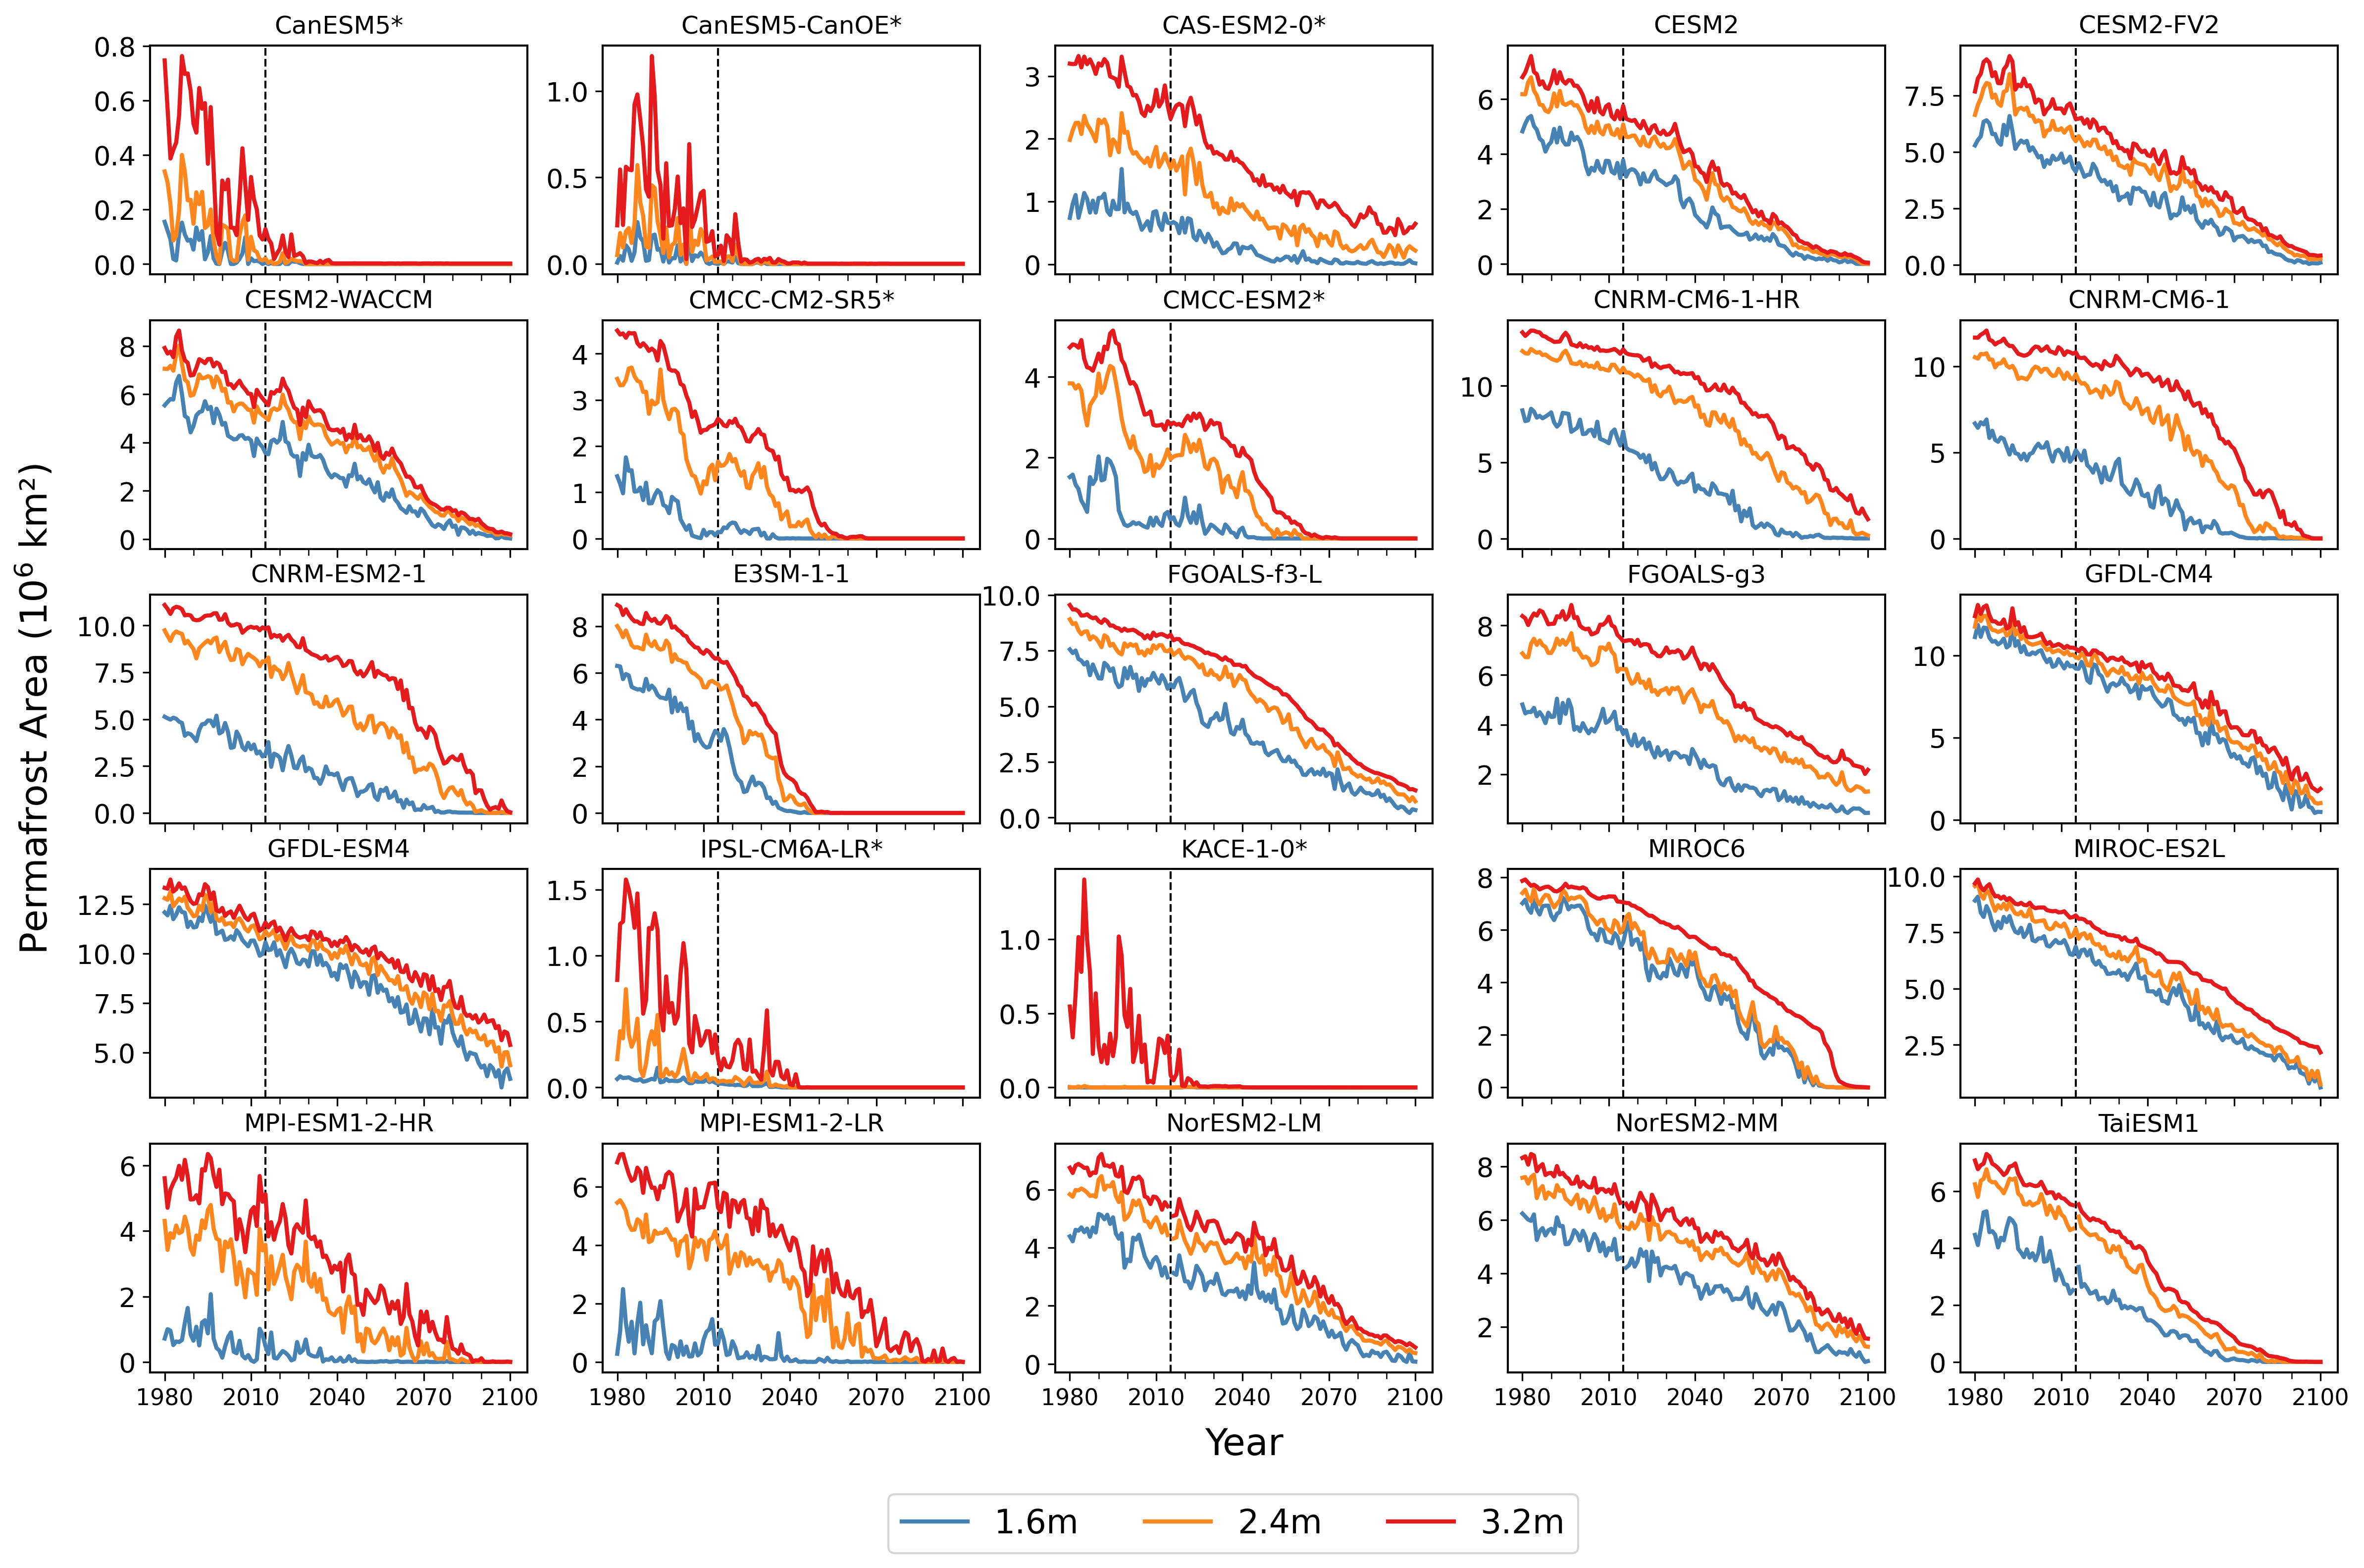

In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import glob
import warnings
warnings.filterwarnings("ignore")

modelname = ["CanESM5", "CanESM5-CanOE", "CAS-ESM2-0", "CESM2", "CESM2-FV2", "CESM2-WACCM", "CMCC-CM2-SR5", "CMCC-ESM2", "CNRM-CM6-1-HR", "CNRM-CM6-1", "CNRM-ESM2-1", "E3SM-1-1", "FGOALS-f3-L", "FGOALS-g3", "GFDL-CM4", "GFDL-ESM4", "IPSL-CM6A-LR", "KACE-1-0", "MIROC6", "MIROC-ES2L", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "NorESM2-LM", "NorESM2-MM", "TaiESM1"]
def load_pfarea_data(model, alt, region):

    folder = f"../Data/Permafrost_area_timeseries_ssp585/cmip6_alt{alt}cm_NH45_EA{region}_pfarea_1980_2100_monthly/"
    files = glob.glob(folder + model + "_*.nc")
    datasets = [Dataset(file) for file in files]
    pfareas = [(ds["pfarea"][:]/ 10**12).filled(np.nan) for ds in datasets]
    
    if len(pfareas) >= 2:
        pfarea_combined = np.concatenate([pfareas[0], np.full(12, np.nan), pfareas[1]])
    else:
        pfarea_combined = np.concatenate(pfareas)
    
    return pfarea_combined

def group_by_year(pfarea, start_year=1980):
    data = pd.DataFrame({"pfarea": pfarea})
    data["year"] = [int(i / 12) + start_year for i in range(len(data))]
    return data.groupby("year")

def process_depth_level(model, alt, region="0_180"):
    pfarea1 = load_pfarea_data(model, alt, region)
    pfarea2 = load_pfarea_data(model, alt, "350_360")
    pfarea_combined = np.nansum([pfarea1, pfarea2], axis=0)
    df = group_by_year(pfarea_combined)
    return [df.get_group(year) for year in df.groups]

fig, axs = plt.subplots(figsize=(19, 14), dpi=300)
i = 0
for model in modelname:
    # Process data for each depth level
    depths = [160, 240, 320]
    minpfareas = {depth: process_depth_level(model, depth) for depth in depths}

    # Create minpfarea DataFrame
    pf1 = pd.DataFrame(columns=["year", "minpfarea1", "minpfarea2", "minpfarea3", "minpfarea4", "minpfarea5"])
    for k, year_groups in enumerate(zip(*minpfareas.values())):
        year = int(year_groups[0].year.mean())
        minpfareas_for_year = [group.pfarea[group.pfarea >= 0].min() if (group.pfarea >= 0).any() else np.nan 
                               for group in year_groups]
        pf1.loc[k] = {"year": year, **{f"minpfarea{idx+1}": val for idx, val in enumerate(minpfareas_for_year)}}
    
    if model in ['NorESM2-LM', 'NorESM2-MM', 'TaiESM1']:
        pf1.loc[pf1.year == 2015, [f"minpfarea{idx+1}" for idx in range(5)]] = np.nan

    # Plotting
    plt.subplot(6, 5, i + 1)
    plt.axvline(x=2015, color='black', linestyle='--', linewidth=1)
    
    colors = ['steelblue', '#ff861d','#e41a1c']
    labels = ['1.6m', '2.4m', '3.2m']
    for idx, (depth, color, label) in enumerate(zip(depths, colors, labels)):
        plt.plot(np.linspace(1980, 2100, 121), pf1[f'minpfarea{idx+1}'].values, ls='-', linewidth=2, c=color, label=label)

    if model in ['CanESM5-CanOE', 'CanESM5', 'IPSL-CM6A-LR', 'KACE-1-0', 'CAS-ESM2-0', "CMCC-CM2-SR5", "CMCC-ESM2"]:
        plt.title(model + '*', fontsize=12)
    else:
        plt.title(model, fontsize=12, c='black')

    plt.yticks(fontsize=13)
    plt.xlim(1975, 2106)

    ax = plt.gca()
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1)

    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(axis='x', direction='out', which='major', length=4)
    ax.tick_params(axis='x', direction='out', which='minor', length=3)

    if i == 21 or i == 22 or i == 23 or i == 24 or i == 20:
        plt.xticks(fontsize=11)
    else:
        plt.xticks(fontsize=6, color='white')

    if i == 10:
        plt.ylabel('Permafrost Area ($10^6$ km²)', fontsize=18, labelpad=10)
    if i == 22:
        plt.legend(ncol=5, fontsize=16, bbox_to_anchor=(1.43, -0.46))
    if i == 22:
        plt.xlabel('Year', fontsize=18, horizontalalignment='center', labelpad=8)

    i += 1

plt.show()

In [2]:
fig.savefig("../Figures/FigureS10.png", bbox_inches='tight',dpi=300)